In [47]:
import model_STN
import Generator_STN
import HeadCT_motion_correction_PAR.Data_processing as dp
import HeadCT_motion_correction_PAR.functions_collection as ff
from HeadCT_motion_correction_PAR.Build_lists import Build_list
import HeadCT_motion_correction_PAR.motion_simulator.transformation as transform
import HeadCT_motion_correction_PAR.STN.model_components as compo
import Bspline
import os
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Try to apply STN on an image

In [188]:
img = nb.load(os.path.join('/mnt/mount_zc_NAS/motion_correction/data/simulated_data_2D_spline/', 'MO101701M000001/MO001A000001/static', 'image_data/recon_partial.nii.gz' )).get_fdata()[:,:,0:30]

In [285]:
tx = 10
ty = 10
tz = 2
rx =  5/ 180 * np.pi
ry =  0 / 180 * np.pi
rz = 5 / 180 * np.pi


# use transformation apply these motions to the image
translation,rotation,scale,transformation_matrix = transform.generate_transform_matrix([tx,ty,tz],[rx,ry,rz], [1,1,1],np.copy(img).shape)
transformation_matrix = transform.transform_full_matrix_offset_center(transformation_matrix, np.copy(img).shape)
img_t = transform.apply_affine_transform(np.copy(img), transformation_matrix, 1, cval = np.min(np.copy(img)) )



In [286]:
# use STN  (complicated!!!)
I = np.expand_dims(np.copy(img)[np.newaxis,...],axis = -1)
img_shape = I.shape

txx = tx / img_shape[1] * 2
tyy = ty / img_shape[2] * 2
tzz = tz / img_shape[3] * 2

## slice is xy plane
I = np.transpose(I,[3,0,1,2,4])

translation = np.array([[1,0, tyy], [0,1,txx ], [0,0,1]]) 
rotation = np.array([[math.cos(-rz), -math.sin(-rz), 0 ], [math.sin(-rz), math.cos(-rz), 0], [0,0,1]])
matrix = np.dot(rotation, translation)[0:2,:]
                
a = [compo.BilinearInterpolation(img_shape[1],img_shape[2])([ii,matrix]) for ii in I]
a = np.transpose(np.stack(a,axis = 0),[1,2,3,0,4])

## slice is xz plane
I = np.transpose(a,[2,0,1,3,4])
translation = np.array([[1,0, tzz], [0,1,0 ], [0,0,1]]) 
rotation = np.array([[math.cos(0), -math.sin(0), 0 ], [math.sin(0), math.cos(0), 0], [0,0,1]])
matrix = np.dot(rotation, translation)[0:2,:]
a = [compo.BilinearInterpolation(img_shape[1],img_shape[3])([ii,matrix]) for ii in I]
a = np.stack(a,axis = 0)
print(a.shape)

I = np.copy(a)
translation = np.array([[1,0, 0], [0,1,0 ], [0,0,1]]) 
rotation = np.array([[math.cos(ry), -math.sin(ry), 0 ], [math.sin(ry), math.cos(ry), 0], [0,0,1]])  ## pay attention to sign
matrix = np.dot(rotation, translation)[0:2,:]
# make the dimesion equal in two sides
II = np.zeros([img_shape[2],img_shape[1],img_shape[1]])
for jj in range(0,II.shape[0]):

    II[jj,...] = dp.crop_or_pad(I[jj,0,:,:,0],[img_shape[1],img_shape[1]],np.min(I))

I = np.transpose(np.expand_dims(np.copy(II)[np.newaxis,...],axis = -1), [1,0,2,3,4])
print(I.shape)

a = [compo.BilinearInterpolation(img_shape[1],img_shape[1])([ii,matrix]) for ii in I]
a = np.squeeze(np.transpose(np.stack(a,axis = 0),[1,2,0,3,4]))
a = dp.crop_or_pad(a,[220,220,30],np.min(a))
a = np.expand_dims(np.copy(a)[np.newaxis,...],axis = -1)

## slice is yz plane
I = np.transpose(a,[1,0,2,3,4])
translation = np.array([[1,0, 0], [0,1,0 ], [0,0,1]]) 
rotation = np.array([[math.cos(-rx), -math.sin(-rx), 0 ], [math.sin(-rx), math.cos(-rx), 0], [0,0,1]]) ## pay attention to sign
matrix = np.dot(rotation, translation)[0:2,:]
# make the dimesion equal in two sides
II = np.zeros([img_shape[1],img_shape[2],img_shape[2]])
for jj in range(0,II.shape[0]):

    II[jj,...] = dp.crop_or_pad(I[jj,0,:,:,0],[img_shape[1],img_shape[1]],np.min(I))

I = np.transpose(np.expand_dims(np.copy(II)[np.newaxis,...],axis = -1), [1,0,2,3,4])
print(I.shape)

a = [compo.BilinearInterpolation(img_shape[2],img_shape[2])([ii,matrix]) for ii in I]
a = np.squeeze(np.transpose(np.stack(a,axis = 0),[1,0,2,3,4]))
STN_result = dp.crop_or_pad(a,[220,220,30],np.min(a))

print(STN_result.shape)

(220, 1, 220, 30, 1)
(220, 1, 220, 220, 1)
(220, 1, 220, 220, 1)
(220, 220, 30)


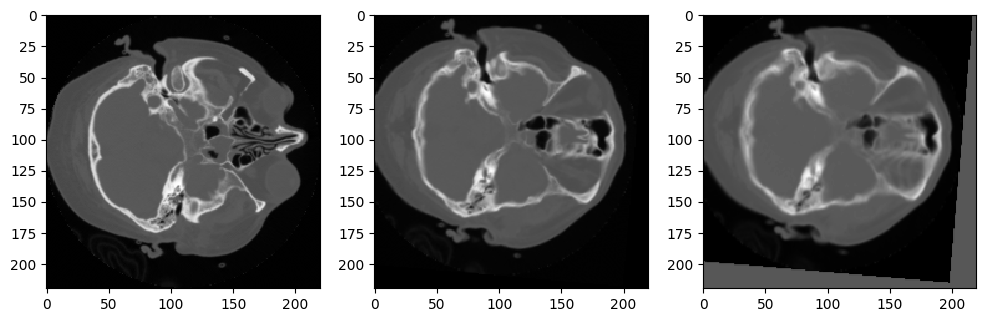

In [287]:
plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(img[:,:,10], 'gray')
plt.subplot(132); plt.imshow(img_t[:,:,10], 'gray')
plt.subplot(133); plt.imshow(STN_result[:,:,10], 'gray')

### Verify STN after the model is trained

(25, 128, 128, 15, 1)


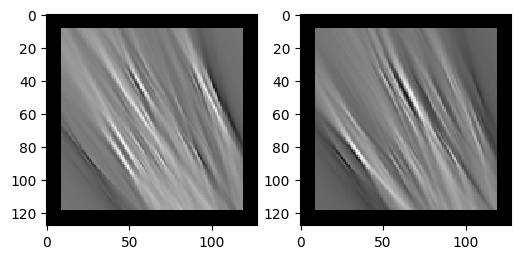

In [20]:
trial_name = 'CNNSTN_on'
data_sheet = os.path.join('/mnt/mount_zc_NAS/motion_correction/data/Patient_list/Patient_list_train_test_PAR_downsampled_dim128_slice0-15.xlsx')
b = Build_list.Build(data_sheet)
batch_list = [0]
_, _, _, _, _, _, _, _, _, _, y_motion_param_tst, x_par_image_tst, y_image_tst = b.__build__(batch_list = batch_list)

image = np.expand_dims(np.load(x_par_image_tst[30],allow_pickle = True),axis = -1)
print(image.shape)
plt.figure(figsize = (6,3))
plt.subplot(121); plt.imshow(image[10,:,:,5,0], 'gray')
plt.subplot(122); plt.imshow(image[10,:,:,10,0], 'gray')


In [5]:
# build model
m = ['3','019']
model_file = ff.find_all_target_files(['*'+m[1]+'.hdf5'],os.path.join('/mnt/mount_zc_NAS/motion_correction/model',trial_name,'models','batch_'+str(m[0])))
model_file = model_file[0]
input_shape = (128,128,15,25)

model_inputs = [Input(input_shape)]
model_outputs=[]
tx,ty, theta, final_image = model_STN.get_CNN(nb_filters = [16,32,64,128,256], dimension = 3, crop_STN = True, crop_size = 30)(model_inputs[0])
model_outputs += [tx]
model_outputs += [ty]
model_outputs += [theta]
model_outputs += [final_image]
  
model = Model(inputs = model_inputs,outputs = model_outputs)
    
model.load_weights(model_file)

array shape:  (None, 25, 60, 60, 2, 1)
final_image shape:  (None, 60, 60, 2, 1)


In [8]:
# get DL prediction
datagen = Generator_STN.DataGenerator(np.asarray([x_par_image_tst[30]]),np.asarray([y_motion_param_tst[30]]), np.asarray([y_image_tst[30]]),
                                    patient_num = 1, 
                                    batch_size = 1, 
                                    input_dimension = input_shape,
                                    output_vector_dimension = (4,),
                                    output_img_dimension =(60,60,2),
                                    shuffle = False,
                                    augment = False,
                                    augment_frequency = 0.2,
                                    seed = 1)
tx, ty, theta, final_image = model.predict_generator(datagen, verbose = 1, steps = 1,)
print(final_image.shape)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
2023-04-02 18:31:19.883125: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-04-02 18:31:19.884432: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2245780000 Hz
2023-04-02 18:31:31.807672: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-04-02 18:31:32.387828: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-04-02 18:31:32.436929: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.s

1/1 [==============================] - 16s 16s/step
(1, 60, 60, 2, 1)


2023-04-02 18:31:35.480509: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [9]:
tx_y = np.concatenate([np.array([0]), tx[0]])
print('tx: ', tx_y)
tx_ys = Bspline.bspline(np.linspace(0,1,5), tx_y, np.linspace(0.04,1,25))
print('tx_ys: ', tx_ys)

ty_y = np.concatenate([np.array([0]), ty[0]])
print('ty: ', ty_y)
ty_ys = Bspline.bspline(np.linspace(0,1,5), ty_y, np.linspace(0.04,1,25))
print('ty_ys: ', ty_ys)

theta_y = np.concatenate([np.array([0]), theta[0]])
print('theta: ', theta_y)
theta_ys = Bspline.bspline(np.linspace(0,1,5), theta_y, np.linspace(0.04,1,25))
print('ty_ys: ', theta_ys)

tx:  [0.         0.0176675  0.03431277 0.04733936 0.04176507]
tx_ys:  [0.00283779 0.00568919 0.00854163 0.01138256 0.01419942 0.01697964
 0.01973535 0.02250449 0.0252581  0.02796427 0.03059109 0.03310667
 0.03553217 0.0380971  0.04067679 0.04308713 0.04514403 0.04666337
 0.04745924 0.04741496 0.04670402 0.045555   0.04419645 0.04285695
 0.04176507]
ty:  [ 0.         -0.01228533 -0.02767569 -0.01965633 -0.00641081]
ty_ys:  [-0.00193227 -0.0038232  -0.00571095 -0.00763368 -0.00962954 -0.01173668
 -0.01413622 -0.01702999 -0.02011186 -0.02305601 -0.02553662 -0.02722788
 -0.02784209 -0.02748801 -0.0264043  -0.02481441 -0.02294176 -0.0210098
 -0.01922283 -0.0173417  -0.01527325 -0.01308173 -0.01083133 -0.00858628
 -0.00641081]
theta:  [ 0.         -0.04732112 -0.09470484 -0.13242096 -0.12444588]
ty_ys:  [-0.00757071 -0.01514058 -0.02271039 -0.0302809  -0.03785289 -0.04542712
 -0.05306551 -0.06085688 -0.0686897  -0.07644441 -0.08400146 -0.09124126
 -0.09818395 -0.10542687 -0.11268053 -0.11950

## Compare DL pictures (made by spatial transformer) vs. our pictures (made by applying DL-predicted MVF to each PAR)

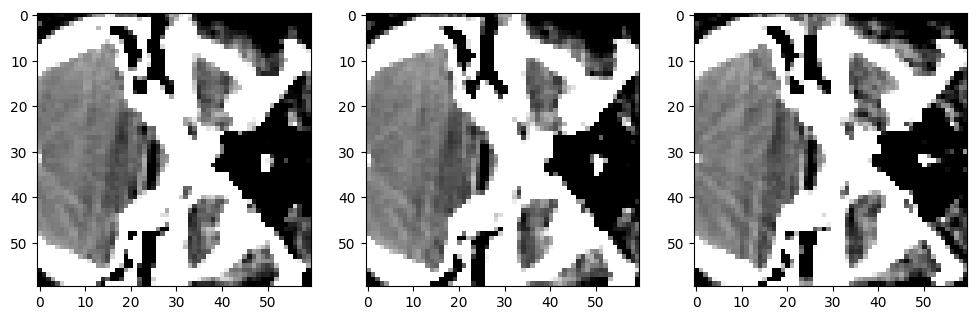

In [22]:
final_t = np.zeros((25,60,60))

for j in range(0,25):
    I = image[j,:,:,10,0]
    t = [-tx_ys[j], -ty_ys[j]]
    t = [tt /2 * 128 for tt in t]
    r = -float(theta_ys[j])

    s = [1,1]
    translation,rotation,scale,transformation_matrix = transform.generate_transform_matrix(t,r,s,I.shape)
    transformation_matrix = transform.transform_full_matrix_offset_center(transformation_matrix, I.shape)
    img_t = transform.apply_affine_transform(I, transformation_matrix, 1, cval = np.min(image) )
    final_t[j,:,:] = img_t[34:94, 34:94]
final_t = np.sum(final_t,axis = 0) / 25

# check final image
final = np.squeeze(final_image) * 1000

# ground truth
y_img = nb.load(y_image_tst[30]).get_fdata(); affine = nb.load(y_image_tst[30]).affine
gt = y_img[(y_img.shape[0]//2 - 30):(y_img.shape[0]//2 + 30), (y_img.shape[1]//2 - 30):(y_img.shape[1]//2 + 30),[5,10]]

# print(final.shape, np.max(final),np.min(final), np.min(final_t),np.min(gt))
plt.figure(figsize = (12,4))
plt.subplot(131); plt.imshow(ff.set_window(final[:,:,1],50,100), 'gray')
plt.subplot(132); plt.imshow(ff.set_window(final_t,50,100), 'gray')
plt.subplot(133); plt.imshow(ff.set_window(gt[:,:,1],50,100), 'gray')

# mae1,_,_,_,_,_ = ff.compare(final[:,:,1], final_t, -100)
# mae2,_,_,_,_,_ = ff.compare(final_t, gt[:,:,1], -100)
# mae3,_,_,_,_,_ = ff.compare(final[:,:,1], gt[:,:,1], -100)
# print(mae1,mae2,mae3)

# nb.save(nb.Nifti1Image(final,affine), '/mnt/mount_zc_NAS/motion_correction/predict.nii.gz')
# nb.save(nb.Nifti1Image(gt,affine), '/mnt/mount_zc_NAS/motion_correction/gt.nii.gz')